In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import glob

In [70]:
file_path = glob.glob(r'**/background.spe')[0]
numbers_bg = []
within_data_section_bg = False
mca_cal_value_bg = None
measured_time_bg = None

with open(file_path, 'r') as file:
    print(f'openned {file_path}')
    for line in file:
        if line.strip() == "$DATA:":
            within_data_section_bg = True
            continue
        
        if line.strip() == "$ROI:":
            within_data_section_bg = False
        
        if within_data_section_bg:
            try:
                num = float(line.split()[0])
                numbers_bg.append(num)
            except ValueError:
                continue

        if line.strip() == "$MCA_CAL:":
            for _ in range(3):
                cal_line = file.readline()
                if cal_line:
                    parts = cal_line.split()
                    if len(parts) >= 2:
                        try:
                            mca_cal_value_bg = float(parts[1])
                        except ValueError:
                            pass

        if line.strip() == "$MEAS_TIM:":
            for _ in range(1):
                cal_line = file.readline()
                if cal_line:
                    parts = cal_line.split()
                    try:
                        measured_time_bg = float(parts[1])
                    except ValueError:
                        pass


background_array = [np.array(numbers_bg[1:]), mca_cal_value_bg, np.array(range(1,1+np.size(np.array(numbers_bg[1:])))), measured_time_bg]

openned voltage_diff\background.spe


In [71]:
file_path = r'Isotropes\co_60.Spe'

Iso_peaks = {
    'co_60' : 1173.2,
    'test' : 69
}

numbers = []
within_data_section = False
mca_cal_value = None
measured_time = None

with open(file_path, 'r') as file:
    for line in file:
        if line.strip() == "$DATA:":
            within_data_section = True
            continue
        
        if line.strip() == "$ROI:":
            within_data_section = False
        
        if within_data_section:
            try:
                num = float(line.split()[0])
                numbers.append(num)
            except ValueError:
                continue

        if line.strip() == "$MCA_CAL:":
            for _ in range(3):
                cal_line = file.readline()
                if cal_line:
                    parts = cal_line.split()
                    if len(parts) >= 2:
                        try:
                            mca_cal_value = float(parts[1])
                        except ValueError:
                            pass

        if line.strip() == "$MEAS_TIM:":
            for _ in range(1):
                cal_line = file.readline()
                if cal_line:
                    parts = cal_line.split()
                    try:
                        measured_time = float(parts[1])
                    except ValueError:
                        pass


counts = np.array(numbers[1:])
mca = mca_cal_value
bins = np.array(range(1,1+np.size(counts)))

print(f'counts prossesed - {np.sum(counts)}, mca value - {mca}, number of bins - {np.size(bins)}, measured time - {measured_time}')

counts prossesed - 24333751.0, mca value - 0.0001910371, number of bins - 8192, measured time - 931.0


In [72]:
background_array[3], measured_time
scale_factor = measured_time/background_array[3]
scale_factor

6.4206896551724135

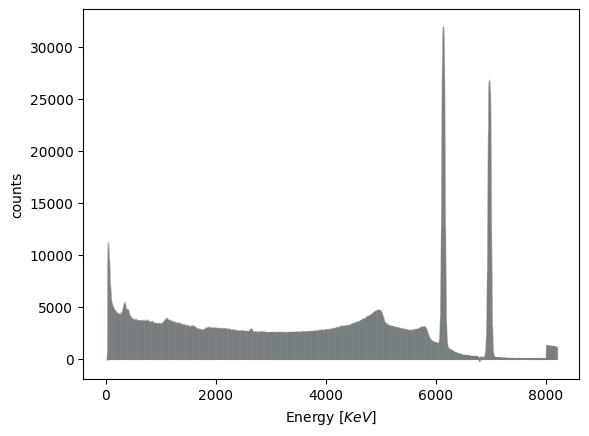

In [73]:
d=100
counts_filterd = counts - background_array[0]*scale_factor

energy = bins*mca
'''
plt.bar(energy, background_array[0], edgecolor='grey', alpha = 0.3)
plt.show()

plt.bar(energy, counts, edgecolor='grey', alpha = 0.3)
plt.show()
'''
plt.bar(bins, counts_filterd, edgecolor='grey', alpha = 0.3)

plt.xlabel(r'Energy [$KeV$]')
plt.ylabel('counts')
plt.show()

[np.int64(6126), np.int64(6966)]


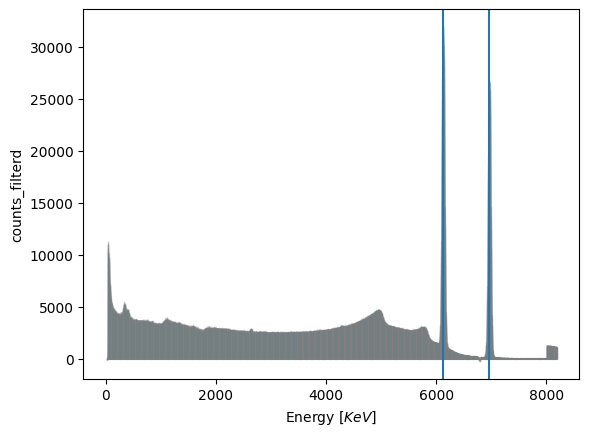

In [74]:
peak_indices, peak_dict = sc.signal.find_peaks(counts_filterd, prominence = 100, height=1, width=10)
peak_heights = peak_dict['peak_heights']
peak_indices=peak_indices

peaks = [peak_indices[np.argmax(peak_heights)], peak_indices[np.argpartition(peak_heights,-2)[-2]]]
num = np.size(peaks)

print(peaks)

plt.bar(bins, counts_filterd, edgecolor='grey', alpha = 0.3)
[plt.axvline(x = bins[c]) for c in peaks]

plt.xlabel(r'Energy [$KeV$]')
plt.ylabel('counts_filterd')
plt.show()

In [76]:
width = 100
activity = 4.2e5
emitted = activity*measured_time

def gaussian(x, amp, mean, std_dev):
    return amp * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)

def inv_gauss(x, amp, mean, std_dev):
    return ((-2*np.log(x/amp))**(1/2)*std_dev+mean)

def fwnm_eq(n, amp, mean, std_dev):
    return (2*np.log(1/n))**(1/2)*std_dev+mean, -(2*np.log(1/n))**(1/2)*std_dev+mean

param_array = np.zeros((num,3))
covariance_array = np.zeros((num,4))
fitted_gaussians = np.zeros((num,width*2))
fwhm_array = np.zeros((num,1))
fwtm_array = np.zeros((num,1))

for c in range(0, num):
    initial_guess = [counts_filterd[peaks[c]],peaks[c], 1]
    popt, pcov = sc.optimize.curve_fit(gaussian, bins[peaks[c]-width:peaks[c]+width], counts_filterd[peaks[c]-width:peaks[c]+width], p0=initial_guess)
    if c == 0:
        mca = Iso_peaks[file_path[file_path.find('\\')+1:-4]]/popt[1]
        print(f'mca value - {mca}')
    popt[1:] = popt[1:]*mca
    param_array[c] = popt
    covariance_array[c] = [np.linalg.cond(pcov), *np.diag(pcov)]
    fwhm_array[c] = 2 * (fwnm_eq(1/2, *popt)[0]-popt[1])
    fwtm_array[c] = 2 * (fwnm_eq(1/10, *popt)[0]-popt[1])
    fitted_gaussians[c] = gaussian(bins[peaks[c]-width:peaks[c]+width], *popt)
    sum_counts = sum(counts_filterd[int(popt[1]/mca-fwhm_array[c]/mca):int(popt[1]/mca+fwhm_array[c]/mca)])
    eff = sum_counts / emitted
    print(f"Peak {c+1}:")
    print(f"  Amplitude = {popt[0]:.2f}, Mean = {popt[1]:.2f} keV, Std Dev = {popt[2]:.2f} keV")
    print(f"  FWHM = {fwhm_array[c][0]:.2f} keV")
    print(f"  Covariance Condition Number = {covariance_array[c][0]:.2e}")
    print(f"  Covariance Diagonal (Variance of Amplitude, Mean, Std Dev) = {covariance_array[c][1]:.2e}, {covariance_array[c][2]:.2e}, {covariance_array[c][3]:.2e}")
    print(f'  Sum of counts at peak - {sum_counts:.2f}')
    print(f'  Efficiency at peak - {eff:.6f}')
    print(f'  Energy resolution - {(fwhm_array[c]/popt[1]*100)[0]:.3f}')
    print(f'  Peak shape fwhm / fwtm - {(fwhm_array[c]/fwtm_array[c])[0]:.3f}')
    #print(f'  Relative efficency - {popt[1]}')
    print("--------------------------------------------------------------")

mca value - 0.1914417792703574
Peak 1:
  Amplitude = 31022.51, Mean = 1173.20 keV, Std Dev = 4.02 keV
  FWHM = 9.48 keV
  Covariance Condition Number = 2.45e+06
  Covariance Diagonal (Variance of Amplitude, Mean, Std Dev) = 4.34e+04, 2.66e-02, 2.66e-02
  Sum of counts at peak - 1606056.24
  Efficiency at peak - 0.004107
  Energy resolution - 0.808
  Peak shape fwhm / fwtm - 0.549
--------------------------------------------------------------
Peak 2:
  Amplitude = 26489.93, Mean = 1333.84 keV, Std Dev = 3.88 keV
  FWHM = 9.14 keV
  Covariance Condition Number = 1.92e+06
  Covariance Diagonal (Variance of Amplitude, Mean, Std Dev) = 4.57e+03, 3.58e-03, 3.58e-03
  Sum of counts at peak - 1324801.88
  Efficiency at peak - 0.003388
  Energy resolution - 0.686
  Peak shape fwhm / fwtm - 0.549
--------------------------------------------------------------


C:\Users\alexa\AppData\Local\Temp\ipykernel_30320\3948114147.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sum_counts = sum(counts_filterd[int(popt[1]/mca-fwhm_array[c]/mca):int(popt[1]/mca+fwhm_array[c]/mca)])


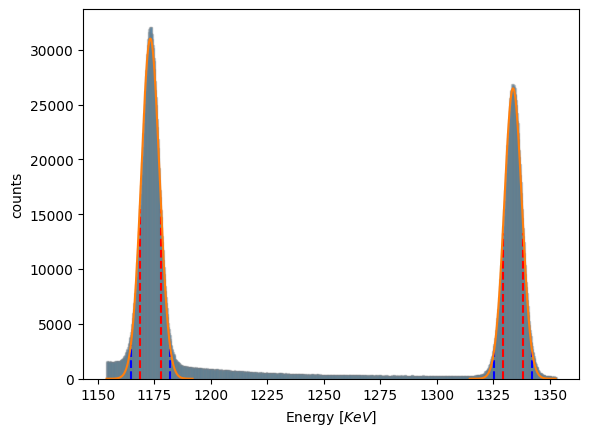

In [77]:
d=100
energy = bins*mca

plt.bar(energy[min(peaks)-d:max(peaks)+d], counts[min(peaks)-d:max(peaks)+d], edgecolor='grey', alpha = 0.3)
[plt.plot([param_array[c][1]-fwhm_array[c]/2,param_array[c][1]-fwhm_array[c]/2], [0, gaussian(param_array[c][1]-fwhm_array[c]/2, *param_array[c])[0]],linestyle = '--', c = 'r') for c in range(0,num)]
[plt.plot([param_array[c][1]+fwhm_array[c]/2,param_array[c][1]+fwhm_array[c]/2], [0, gaussian(param_array[c][1]-fwhm_array[c]/2, *param_array[c])[0]],linestyle = '--', c = 'r') for c in range(0,num)]
[plt.plot([param_array[c][1]-fwtm_array[c]/2,param_array[c][1]-fwtm_array[c]/2], [0, gaussian(param_array[c][1]-fwtm_array[c]/2, *param_array[c])[0]],linestyle = '--', c = 'b') for c in range(0,num)]
[plt.plot([param_array[c][1]+fwtm_array[c]/2,param_array[c][1]+fwtm_array[c]/2], [0, gaussian(param_array[c][1]-fwtm_array[c]/2, *param_array[c])[0]],linestyle = '--', c = 'b') for c in range(0,num)]
[plt.plot(energy[peaks[c]-width:peaks[c]+width], gaussian(energy[peaks[c]-width:peaks[c]+width], *param_array[c]), c='tab:orange') for c in range(0, num)]

plt.xlabel(r'Energy [$KeV$]')
plt.ylabel('counts')
plt.show()

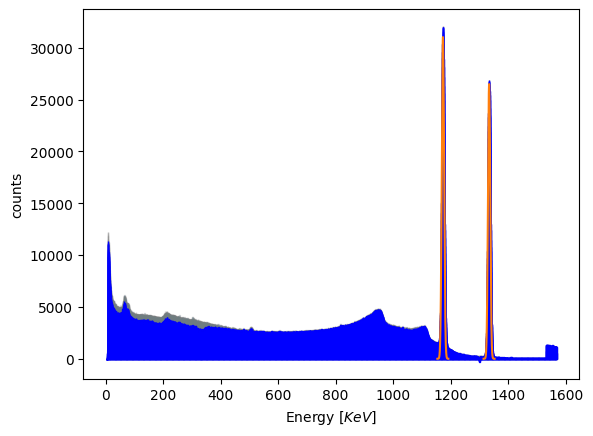

In [41]:
d=100
energy = bins*mca

plt.bar(energy, counts, edgecolor='grey', alpha = 0.3)
plt.bar(energy, counts_filterd, edgecolor='b')

[plt.plot(energy[peaks[c]-width:peaks[c]+width], gaussian(energy[peaks[c]-width:peaks[c]+width], *param_array[c]), c='tab:orange') for c in range(0, num)]

plt.xlabel(r'Energy [$KeV$]')
plt.ylabel('counts')
plt.show()

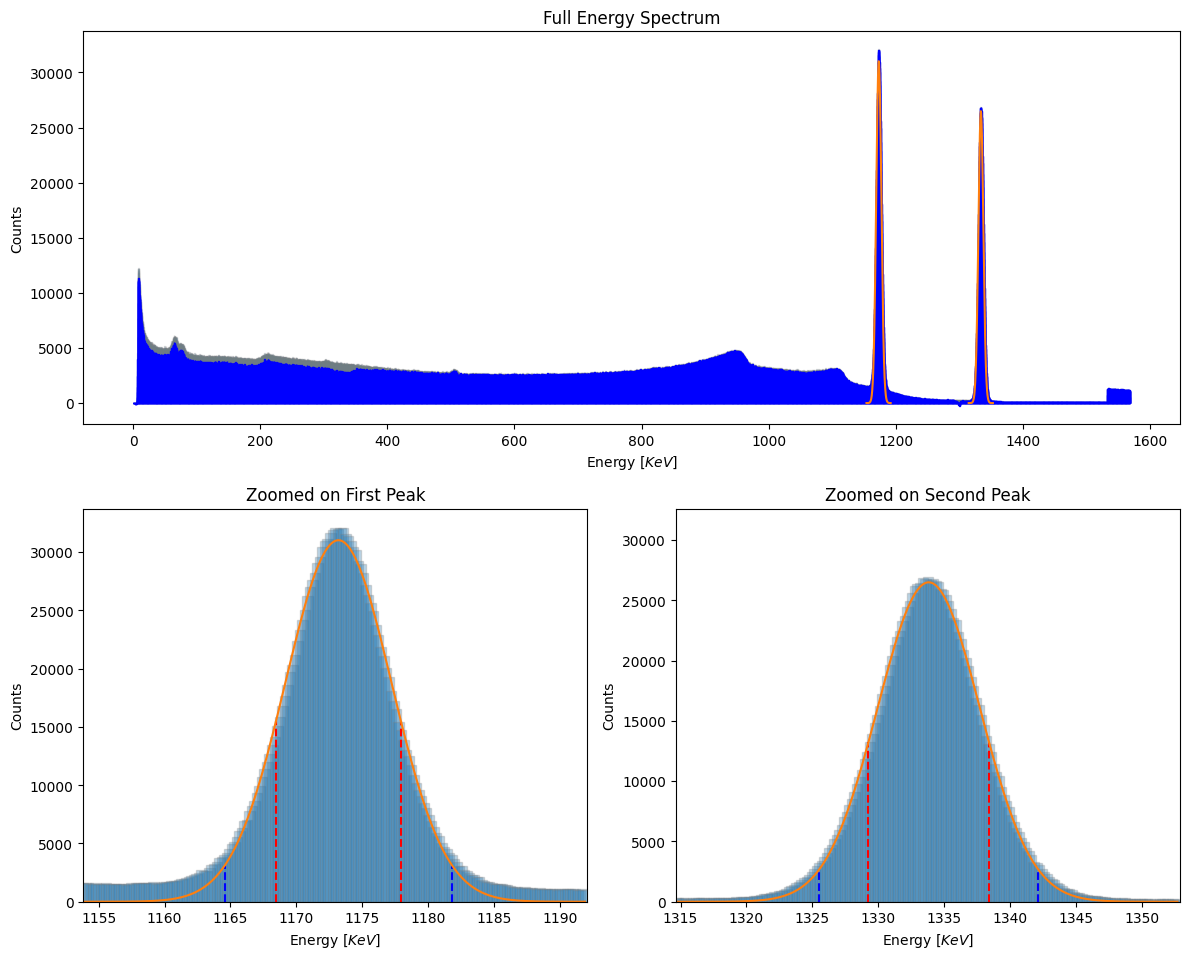

In [42]:
# Create a figure with three subplots: one on top, two on the bottom
fig = plt.figure(figsize=(12, 14))

# Define the subplots
ax1 = fig.add_subplot(3, 1, 1)  # Top subplot (full view)
ax2 = fig.add_subplot(3, 2, 3)  # Bottom-left subplot (zoomed-in on first peak)
ax3 = fig.add_subplot(3, 2, 4)  # Bottom-right subplot (zoomed-in on second peak)

# First graph on the top subplot (ax1)
energy = bins * mca
ax1.bar(energy, counts, edgecolor='grey', alpha=0.3)
ax1.bar(energy, counts_filterd, edgecolor='b')
[ax1.plot(energy[peaks[c]-width:peaks[c]+width], gaussian(energy[peaks[c]-width:peaks[c]+width], *param_array[c]), c='tab:orange') for c in range(0, num)]

# Labeling for the first graph
ax1.set_xlabel(r'Energy [$KeV$]')
ax1.set_ylabel('Counts')
ax1.set_title('Full Energy Spectrum')

# Bottom-left graph (ax2): Zoomed-in on the first peak
d = 100  # Range to zoom in around the peak
first_peak = peaks[0]  # Assuming the first peak is at index 0

ax2.bar(energy[first_peak - d:first_peak + d], counts[first_peak - d:first_peak + d], edgecolor='grey', alpha=0.3)
[ax2.plot([param_array[c][1]-fwhm_array[c]/2, param_array[c][1]-fwhm_array[c]/2], 
          [0, gaussian(param_array[c][1]-fwhm_array[c]/2, *param_array[c])[0]], linestyle='--', c='r') for c in range(0, num)]
[ax2.plot([param_array[c][1]+fwhm_array[c]/2, param_array[c][1]+fwhm_array[c]/2], 
          [0, gaussian(param_array[c][1]-fwhm_array[c]/2, *param_array[c])[0]], linestyle='--', c='r') for c in range(0, num)]
[ax2.plot([param_array[c][1]-fwtm_array[c]/2, param_array[c][1]-fwtm_array[c]/2], 
          [0, gaussian(param_array[c][1]-fwtm_array[c]/2, *param_array[c])[0]], linestyle='--', c='b') for c in range(0, num)]
[ax2.plot([param_array[c][1]+fwtm_array[c]/2, param_array[c][1]+fwtm_array[c]/2], 
          [0, gaussian(param_array[c][1]-fwtm_array[c]/2, *param_array[c])[0]], linestyle='--', c='b') for c in range(0, num)]
[ax2.plot(energy[peaks[c]-width:peaks[c]+width], gaussian(energy[peaks[c]-width:peaks[c]+width], *param_array[c]), c='tab:orange') for c in range(0, num)]

# Labeling for the bottom-left graph
ax2.set_xlabel(r'Energy [$KeV$]')
ax2.set_ylabel('Counts')
ax2.set_title('Zoomed on First Peak')
ax2.set_xlim(energy[first_peak - d], energy[first_peak + d])

# Bottom-right graph (ax3): Zoomed-in on the second peak
second_peak = peaks[1]  # Assuming the second peak is at index 1

ax3.bar(energy[second_peak - d:second_peak + d], counts[second_peak - d:second_peak + d], edgecolor='grey', alpha=0.3)
[ax3.plot([param_array[c][1]-fwhm_array[c]/2, param_array[c][1]-fwhm_array[c]/2], 
          [0, gaussian(param_array[c][1]-fwhm_array[c]/2, *param_array[c])[0]], linestyle='--', c='r') for c in range(0, num)]
[ax3.plot([param_array[c][1]+fwhm_array[c]/2, param_array[c][1]+fwhm_array[c]/2], 
          [0, gaussian(param_array[c][1]-fwhm_array[c]/2, *param_array[c])[0]], linestyle='--', c='r') for c in range(0, num)]
[ax3.plot([param_array[c][1]-fwtm_array[c]/2, param_array[c][1]-fwtm_array[c]/2], 
          [0, gaussian(param_array[c][1]-fwtm_array[c]/2, *param_array[c])[0]], linestyle='--', c='b') for c in range(0, num)]
[ax3.plot([param_array[c][1]+fwtm_array[c]/2, param_array[c][1]+fwtm_array[c]/2], 
          [0, gaussian(param_array[c][1]-fwtm_array[c]/2, *param_array[c])[0]], linestyle='--', c='b') for c in range(0, num)]
[ax3.plot(energy[peaks[c]-width:peaks[c]+width], gaussian(energy[peaks[c]-width:peaks[c]+width], *param_array[c]), c='tab:orange') for c in range(0, num)]

# Labeling for the bottom-right graph
ax3.set_xlabel(r'Energy [$KeV$]')
ax3.set_ylabel('Counts')
ax3.set_title('Zoomed on Second Peak')
ax3.set_xlim(energy[second_peak - d], energy[second_peak + d])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the combined plot
plt.show()